In [1]:
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import numpy as np


In [2]:
X, Y = datasets.load_digits(return_X_y=True)
X = np.ascontiguousarray(X.astype("d")) / 16.

In [3]:
def binarize(Y, n):
    N = len(Y)
    data = np.zeros((N,n), 'd')
    rows = []
    for k in range(N):
        data[k, Y[k]] = 1
    data = 2*data-1
    return data

Y2 = binarize(Y, 10)
print(Y2.shape, X.shape)
n_input = X.shape[1]
print(n_input)
print(Y2)

(1797, 10) (1797, 64)
64
[[ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]]


In [4]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score

In [5]:
def calc_zz(mod, xr, yr):
    xrange = np.linspace(xr[0], xr[1], 101)
    yrange = np.linspace(yr[0], yr[1], 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate_all(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

In [6]:
def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    ymax = np.asarray(mod.param.base[1:].copy())
    ymin = np.asarray(mod.param.base[1:].copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    print(n)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    # ax.legend(loc="upper right")
    ax.legend()    

In [7]:
def clf_func(ffnn, x):
    return (np.sign(ffnn(x))+1)/2

In [8]:
import mlgrad.gd as gd
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
from mlgrad.cls import classification_as_regr22
import mlgrad.plots as plots

In [9]:
hinge_loss = loss.MarginLoss(funcs.Hinge(0))
l2_reg = funcs2.SquareNorm()
l1_reg = funcs2.AbsoluteNorm()
sigmoidal_func = funcs.Sigmoidal(6.0)
sq_loss = loss.ErrorLoss(funcs.Square())

In [10]:
n_hidden = 50
body = models.FFNetworkModel()
body.add(models.LinearLayer(n_input, n_hidden))
body.add(models.ScaleLayer(sigmoidal_func, n_hidden))
body.add(models.LinearLayer(n_hidden, 10))
# body.add(models.ScaleLayer(sigmoidal_func, 10))
nnmod = body

In [11]:
nnmod.allocate()
nnmod.init_param()
nnmod.param[:] = (2*nnmod.param.base-1) * 0.01

In [17]:
alg = classification_as_regr22(X, Y2, nnmod,
                             lossfunc=loss.ErrorMultLoss2(funcs.Square()),
                             normalizer=gd.Masked(nnmod.n_param, 1.0e-4),
                             regnorm=l1_reg, tau=0.05,
                             h=0.001)

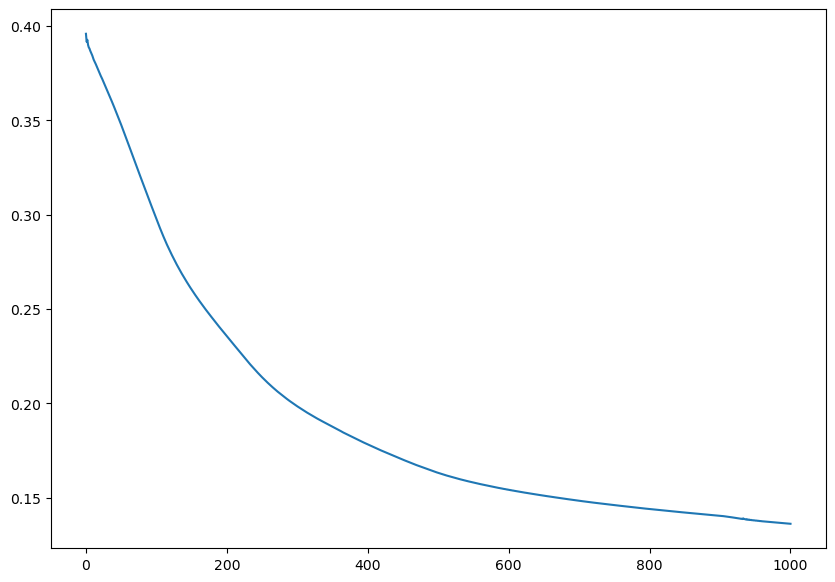

0.9894268224819143

In [18]:
plt.figure(figsize=(10,7))
plt.plot(alg.lvals)
plt.show()
Y_p = [np.argmax(nnmod(x)) for x in X]
accuracy_score(Y, Y_p)

3759


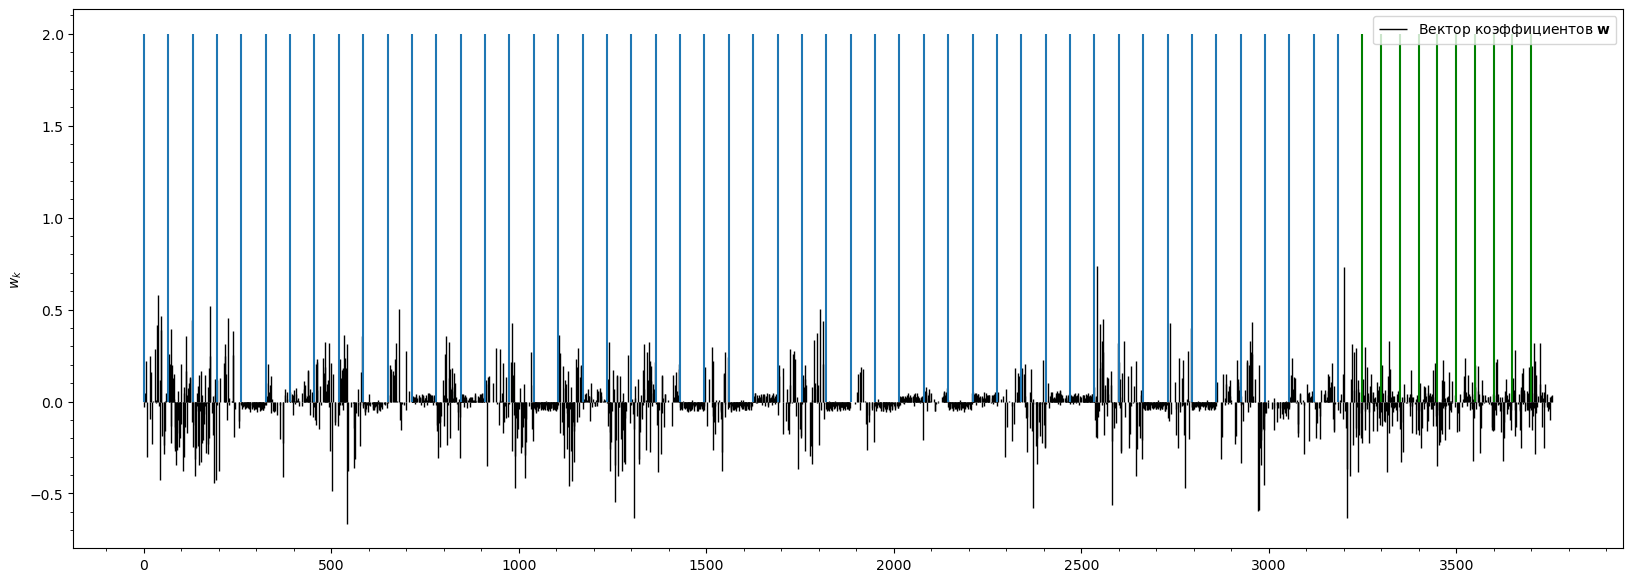

In [16]:
plt.figure(figsize=(20,7))
plot_params(nnmod)
plt.vlines([(X.shape[1]+1)*i for i in range(n_hidden)], 0, 2)
plt.vlines([(X.shape[1]+1)*n_hidden + i*n_hidden for i in range(10)], 0, 2, colors='g')
plt.show()